## softmax回归的从零开始实现

In [3]:
!pip install d2l

In [4]:
import torch 
from IPython import display
from d2l import torch as d2l

In [5]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
num_inputs = 784
num_outputs = 10
 
W = torch.normal(0,0.01,size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [7]:
X = torch.tensor([[1.0, 2.0, 3.0],[4.0, 5.0, 6.0]])
X.sum(0, keepdim=True) ,X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]), tensor([[ 6.],
         [15.]]))

实现softmax

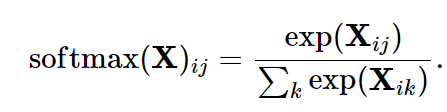softmax(X)ij=exp(Xij)∑kexp(Xik).

In [8]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1,keepdim=True)
  return X_exp / partition

#### 测试sum（）的keep_dim()
keep_dim()保持维度，当加起来只有一个数字的时候，也会占一行或者一列，不会被squeeze（压缩）。

In [13]:
X_exp1 = torch.exp(X)
X_exp1.sum(1,keepdim=True).shape

torch.Size([2, 1])

In [12]:
X_exp1 = torch.exp(X)
X_exp1.sum(1).shape

torch.Size([2])

### 继续实现softmax


In [9]:
import torch
X = torch.normal(0,1,(2,5))
X_prob = softmax(X)
X_prob,X_prob.sum(1)


(tensor([[0.0463, 0.0125, 0.5471, 0.0533, 0.3409],
         [0.2710, 0.1416, 0.0883, 0.2883, 0.2108]]), tensor([1.0000, 1.0000]))

#### 测试softmax的dim参数

In [18]:
import torch.nn as nn
m = nn.Softmax(dim=1)
input = torch.randn(1, 3)
output = m(input)

In [19]:
output

tensor([[0.5721, 0.0744, 0.3535]])

In [20]:
input

tensor([[ 1.2813, -0.7584,  0.8000]])

In [24]:
myinput = torch.tensor([  -0.7584,1.2813,  0.8000])
m = nn.Softmax(dim=0)
m(myinput)

tensor([0.0744, 0.5721, 0.3535])

### 实现softmax回归模型

In [10]:
def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)


In [11]:
y = torch.tensor([0,2])
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

In [12]:
def cross_entropy(y_hat, y):
  return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [13]:
def accuracy(y_hat,y):
  if len(y_hat.shape)>1 and y_hat.shape[1]>1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.type(y.dtype) == y
  return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

In [14]:
def evaluate_accuracy(net, data_iter):
  if isinstance(net, torch.nn.Module):
    net.eval()
  metric = Accumulator(2)
  for X,y in data_iter:
    metric.add(accuracy(net(X),y), y.numel())
  return metric[0] / metric[1]

In [15]:
class Accumulator:
  def __init__(self,n):
    self.data = [0.0]*n
  
  def add(self,*args):
    self.data = [a + float(b) for a,b in zip(self.data,args)]
  
  def reset(self):
    self.data = [0.0] * len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx]

evaluate_accuracy(net,test_iter)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.0998

### Softmax回归的训练

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net,torch.nn.Module):
    net.train()

  metric = Accumulator(3)
  for X,y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater,torch.optim.Optimizer):
      updater.zero_grad()
      l.backward()
      updater.step()
      metric.add(
          float(1)*len(y),accuracy(y_hat,y),
          y.size().numel()
      )
    else:
      l.sum().backward()
      updater(X.shape[0])
      metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
  